# Inverted Pendulum Control
## Summary
This notebook outlines state space controller design for an inverted pendulum on a cart.

This is a classic engineering school design problem. This notebook is light on theory and borrows heavily from the excellent outline by [University of Michigan Engineering Control Tutorials](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling).

Please refer to the above webpage if you wish to delve further into the theory.

## Goals
The ultimate goal is to apply the control system to a simulated environment - for this I have chosen Python and specifially [pymunk](http://www.pymunk.org) as the 2D physics simulator and [pyglet](http://www.pyglet.org) as the game engine to render the results.

### Control System Requirements
The design criteria for this system with the cart receiving a 0.2 m step input are as follows:
* Settling time for x and theta of less than 5 seconds
* Rise time for x of less than 1 second
* Overshoot of theta less than 20 degrees (0.35 radians)

## Variables and constants
* M mass of the cart 0.5 kg
* m mass of the pendulum 0.2 kg
* b friction of the cart 0.1 N/m/sec
* l length to pendulum center of mass 0.6 m
* i inertia of the pendulum 0.001 $kg*m^2$
* F force applied to the cart
* x cart position coordinate
* theta pendulum angle from vertical

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.linalg
import math

In [2]:
# constants for model
M = 0.5   # mass of cart
m = 0.2   # mass of pendulum
b = 0.1   # friction of cart
l = 0.6   # length to pendulum center of mass
i = 0.001 # inertia of pendulum
g = 9.81  # gravity

In [3]:
# state space model
p = i*(M+m)+M*m*l**2  # denominator for the A and B matricies
A = np.matrix([
    [0,              1,             0, 0], 
    [0, -(i+m*l**2)*b/p, (m**2*g*l**2)/p, 0], 
    [0,              0,             0, 1], 
    [0,     -(m*l*b)/p, m*g*l*(M+m)/p, 0]
])
B = np.matrix([
    [0],
    [(i+m*l**2)/p],
    [0],
    [m*l/p]
])
C = np.matrix([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])
D = np.matrix([
    [0],
    [0]
])

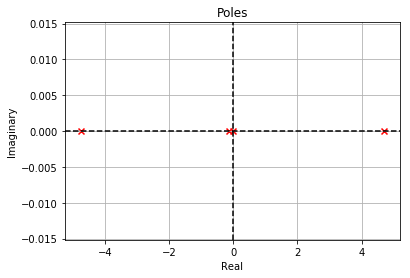

In [4]:
# plot the poles to look at open loop system stability
poles = scipy.linalg.eigvals(A)
plt.scatter([p.real for p in poles], [p.imag for p in poles], color='red', marker='x')
plt.axvline(0, color='k', linestyle='dashed')
plt.axhline(0, color='k', linestyle='dashed')
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles')
plt.show()

In [5]:
# system controllability - if rank[B, AB, A^2B, A^3B] == 4, it is controllable
RM = np.concatenate((B, A * B, np.linalg.matrix_power(A, 2) * B, np.linalg.matrix_power(A, 3) * B), axis=1)
if np.linalg.matrix_rank(RM) == A.shape[0]:
    print('System is controllable')
else:
    print('System is NOT controllable!')

System is controllable


In [6]:
# system observability
OM = np.concatenate((C, C * A, C * np.linalg.matrix_power(A, 2), C * np.linalg.matrix_power(A, 3)), axis=0)
if np.linalg.matrix_rank(OM) == A.shape[0]:
    print('System is observable')
else:
    print('System is NOT observable!')

System is observable


### System Overview
System is controllable and observable, and because it has a pole in the RHS, it is unstable

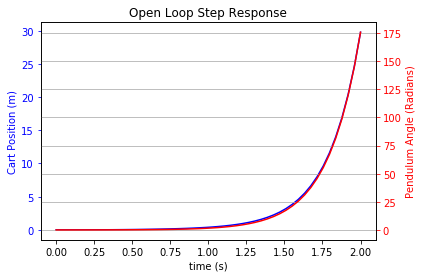

In [7]:
# system has a pole in the right hand plane and looks unstable, simulate the step response with 0 initial conditions
system = scipy.signal.lti(A, B, C, D)
t = np.linspace(0, 2)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.lsim(system, u, t)

fig, ax1 = plt.subplots()
ax1.plot(tout, yout[:, :1], 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(tout, yout[:, 1:], 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.grid(True)
plt.title('Open Loop Step Response')
plt.show()

In [8]:
# define an LQR function, adapted from http://www.mwm.im/lqr-controllers-with-python/
def lqr(A, B, Q, R):
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R) * (B.T * X))
    return K

In [9]:
# find structure of Q
C.T * C

matrix([[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]])

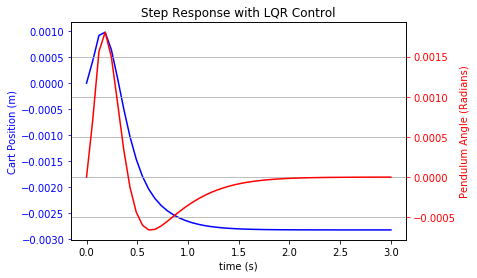

In [10]:
# element in 0,0 position used to weight cart's position, element in 2,2 position to weight pendulum angle
x = 5000
y = 100

Q = np.matrix([
    [x, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, y, 0],
    [0, 0, 0, 0]
])
R = np.ones((1, 1));
K = lqr(A, B, Q, R)

# simulate the system with the calculated gain
Ac = A - B * K 
system = scipy.signal.lti(Ac, B, C, D)
t = np.linspace(0, 3)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.lsim(system, u, t)

fig, ax1 = plt.subplots()
ax1.plot(tout, yout[:, :1], 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(tout, yout[:, 1:], 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.grid(True)
plt.title('Step Response with LQR Control')
plt.show()

In [11]:
# adapted from: http://ctms.engin.umich.edu/CTMS/index.php?aux=Extras_rscale
def rscale(A, B, C, D, K):
    s = A.shape[0]
    Z = np.append(np.zeros((1, s)), 1)
    ABcat = np.concatenate((A, B), axis=1)
    CDcat = np.concatenate((C, D), axis=1)
    ABCDinv = np.linalg.inv(np.concatenate((ABcat, CDcat), axis=0))
    N = ABCDinv.dot(Z.T)
    Nx = N.A[0][0:s]
    Nu = N.A[0][s]
    if hasattr(K, 'gain_matrix'):
        Nbar = Nu + K.gain_matrix.dot(Nx)
    else:
        Nbar = Nu + K.dot(Nx)
    return Nbar

### What is 'rscale'?
We want to be able to provide the cart position (x-direction) as an input - the rscale function let's us map this input to something the system understands - in this case the x-direction force applied to the cart.

If you look at the above graph, we have applied a step input of 0.2 and this has resulted in a stable system (pendulum angle is at 0) but the x-position of the cart is not at 0.2.

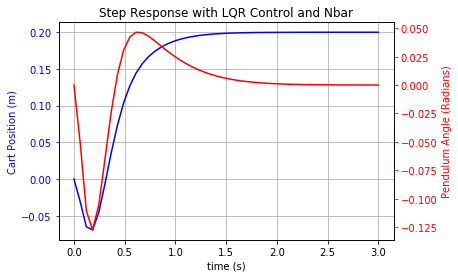

In [12]:
# let's remove steady state error - step input is 0.2m so we want the cart to reach this position
# "A different C had to be used because the rscale function will not work for multiple outputs"
Cn = C[:1]
Dn = D[:1,0]
Nbar = rscale(A, B, Cn, Dn, K)

# simulate the system with Nbar - we should see the cart position reach steady state of 0.2m
Bcn = B.dot(Nbar)
system = scipy.signal.lti(Ac, Bcn, C, D)
t = np.linspace(0, 3)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.lsim(system, u, t)

fig, ax1 = plt.subplots()
ax1.plot(tout, yout[:, :1], 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(tout, yout[:, 1:], 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.title('Step Response with LQR Control and Nbar')
plt.show()

### System Design Results
We have now met our design requirements:
* Settling time for x and theta of less than 5 seconds
* Rise time for x of less than 1 second
* Overshoot of theta less than 20 degrees (0.35 radians)

### Digital Controller Design
Because our physics simulation is in discrete time, we need to convert our system to discrete time and perform similar steps. We will be sampling the states 60 times per second in the simulation.

In [13]:
# let's convert the system into discrete time, so we can simulate with pymunk physics engine and pyglet game engine
# we'll sample state 60 times per second
ts = 1.0/60.0
F, G, H, J, dt = scipy.signal.cont2discrete((A, B, C, D), ts)
dsystem = (F, G, H, J, dt)

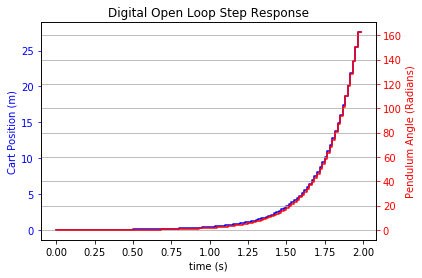

In [14]:
# test the open loop system against a step input
system = scipy.signal.dlti(F, G, H, J)
tsim = 2
samples = math.ceil(tsim / ts)
t = np.linspace(0, tsim, samples)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.dlsim(system, u)

fig, ax1 = plt.subplots()
ax1.step(tout * dt, yout[:, :1], 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.step(tout * dt, yout[:, 1:], 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.grid(True)
plt.title('Digital Open Loop Step Response')
plt.show()

In [15]:
# define an discrete time LQR function - created using the following reference:
# https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator
def dlqr(A, B, Q, R):
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R + B.T * P * B) * (B.T * P * A))
    return K

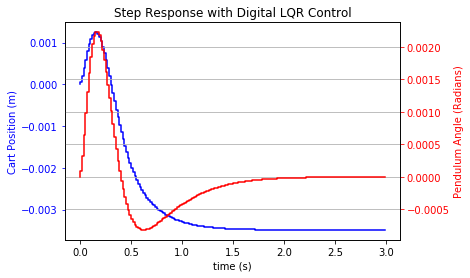

In [16]:
# design digital LQR controller - using same gains as before
x = 5000
y = 100
Qd = np.matrix([
    [x, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, y, 0],
    [0, 0, 0, 0]
])
R = np.ones((1, 1));
Kd = dlqr(F, G, Qd, R)

# simulate the system with the calculated gain
Fc = F - G * Kd
system = scipy.signal.dlti(Fc, G, H, J)
tsim = 3
samples = math.ceil(tsim / ts)
t = np.linspace(0, tsim, samples)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.dlsim(system, u)

fig, ax1 = plt.subplots()
ax1.step(tout * dt, yout[:, :1], 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.step(tout * dt, yout[:, 1:], 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.grid(True)
plt.title('Step Response with Digital LQR Control')
plt.show()

In [17]:
Nbar

matrix([[-70.71067812]])

### Digital Nbar
We can't use the original rscale function because it is for a continuous time (CT) system, but we can use the CT Nbar value as a starting point and manually tweak it to get our steady state to the desired 0.2 m output.

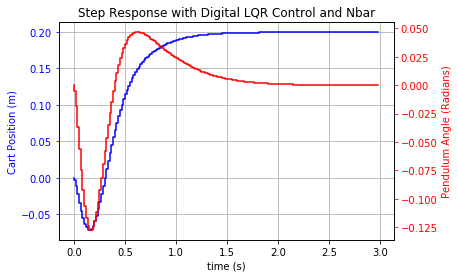

In [18]:
# let's remove steady state error - step input is 0.2 m so we want the cart to reach this position
# we can't use rscale since it was for continuous time (CT) systems, but we can use CT Nbar as a starting point 
# and tweak it
# using trial and error - started with Nbar value
Nbard = np.matrix([[-57.25]])

# simulate the system with Nbar - we should see the cart position reach steady state of 0.2 m if Nbard is set 
# appropriately
Gcn = G * Nbard
system = scipy.signal.dlti(Fc, Gcn, H, J)
tsim = 3
samples = math.ceil(tsim / ts)
t = np.linspace(0, tsim, samples)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.dlsim(system, u)

fig, ax1 = plt.subplots()
ax1.step(tout * dt, yout[:, :1], 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.step(tout * dt, yout[:, 1:], 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.title('Step Response with Digital LQR Control and Nbar')
plt.show()

In [19]:
# dump out our gain matrix so we can use it in our simulation
Kd

matrix([[-57.38901804, -36.24133932, 118.51380879,  28.97241832]])

### Applying this to Code
We can derive the function for our input (u) using the following diagram of the system:  
![State Feedback with Precompensation](http://ctms.engin.umich.edu/CTMS/Content/InvertedPendulum/Control/StateSpace/figures/statefeedback_w_pre_pend.png "State Feedback with Precompensation")  

$\vec{u} = \vec{r} * N - K * \vec{x}$

Where $\vec{r}$ is our desired results (just the x-position of the cart in this case), N is our digital Nbar matrix (a 1x1 matrix in this case), K is our digital gain matrix, and $\vec{x}$ is the state vector. 

There are 4 values in the gain matrix K that correspond to the 4 states we are measuring: 
* cart x-position
* cart x-velocity
* pendulum angle from vertical
* pendulum angular velocity.

The input vector $\vec{u}$ in this case only has the x-direciton force to apply to the cart.

In practice, the code will look something like this:

```python
# this code would sit in some periodic loop (at our sampling rate, which in this case is 60 times per second)

# constants - gain matrix and Nbar
K = [-57.38901804, -36.24133932, 118.51380879,  28.97241832]
Nbar = -57.25

# the following states would be sampled
# posx is cart position (x-direction)
# velx is cart velocity (x-direction)
# ang is pendulum angle
# angv is pendulum angular velocity

# calculate the gain based on the current state
gain = K[0] * posx + K[1] * velx + K[2] * ang + K[3] * angv

# calculate the required force (u)
# ref is our desired x-position of the cart - in our examples this was 0.2 m
force = ref * NBAR - gain

# we can now apply this force to the cart center of mass (in the x-direction)
```

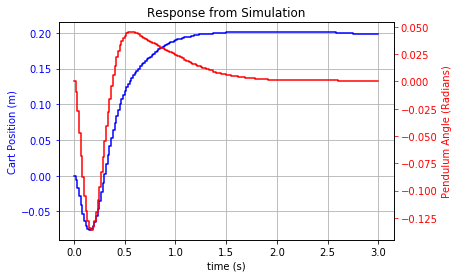

In [20]:
# plot results from simulation run in pyglet/pymunk
import csv

t, x, theta = [], [], []
with open('../data/invpend.csv', 'r') as f:
    for row in csv.reader(f):
        t.append(row[0])
        x.append(row[1])
        theta.append(row[2])

# ignore first row (labels) and convert data to floats
t = [float(a) for a in t[1:]]
x = [float(a) for a in x[1:]]
theta = [float(a) for a in theta[1:]]

fig, ax1 = plt.subplots()
ax1.step(t, x, 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cart Position (m)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.step(t, theta, 'r-')
ax2.set_ylabel('Pendulum Angle (Radians)', color='r')
ax2.tick_params('y', colors='r')

plt.title('Response from Simulation')
plt.show()